In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Функция для создания датасета для LSTM
def create_lstm_dataset(data, time_steps=1, forecast_days=1):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_days + 1):
        end_ix = i + time_steps
        out_end_ix = end_ix + forecast_days
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define the function to create LSTM dataset and save it
def create_and_save_lstm_dataset(file_id, n_intervals, datasets_folder='../datasets', scalers_folder='../scalers'):
    file_path = '../data_updated/' + file_names[file_id]
    dataset = pd.read_csv(file_path).dropna()

    target_column = dataset.pop('Цена')
    dates = dataset.pop('Дата')
    dataset['Цена'] = target_column

    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_dataset = scaler.fit_transform(dataset)


    X_ltsm, y_ltsm = create_lstm_dataset(normalized_dataset, n_intervals, forecast_days=1)

    train_size = int(len(X_ltsm) * 0.8)
    X_train_ltsm, X_test_ltsm = X_ltsm[:train_size], X_ltsm[train_size:]
    y_train_ltsm, y_test_ltsm = y_ltsm[:train_size], y_ltsm[train_size:]

    scaler_filename = '../scalers/'+file_names[file_id]+'_scaler.pkl'
    with open(scaler_filename, 'wb') as scaler_file:
        joblib.dump(scaler, scaler_file)

    # Сохранение данных X_train и y_train_ltsm
    X_train_ltsm_file_path = os.path.join(datasets_folder, f'X_train_ltsm_{file_names[file_id]}')
    X_test_ltsm_file_path = os.path.join(datasets_folder, f'X_test_ltsm_{file_names[file_id]}')
    y_train_ltsm_file_path = os.path.join(datasets_folder, f'y_train_ltsm_{file_names[file_id]}')
    y_test_ltsm_file_path = os.path.join(datasets_folder, f'y_test_ltsm_{file_names[file_id]}')

    np.save(X_train_ltsm_file_path, X_train_ltsm)
    np.save(X_test_ltsm_file_path, X_test_ltsm)
    np.save(y_train_ltsm_file_path, y_train_ltsm)
    np.save(y_test_ltsm_file_path, y_test_ltsm)

    print(f'Data saved to {X_train_ltsm_file_path} and {X_test_ltsm_file_path}')
    print(f'Data saved to {y_train_ltsm_file_path} and {y_test_ltsm_file_path}')

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import sqrt
from keras.losses import mean_squared_error

from free_utils import *

# # Путь к сохраненной модели
# saved_model_path = 'models/Прошлые данные - LKOH.csv_LSTM_100xTrue_LSTM_100xFalse_Dense256_Dense256_Dense1_best_model.h5'
# 
# # Загружаем модель
# loaded_model = load_model(saved_model_path)
# model = loaded_model



C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [16]:
# Загрузка данных
file_id = 11 # Замените на нужный идентификатор файла
n_intervals = 120  # Замените на необходимое количество временных интервалов
n_features = 18  # Замените на количество признаков в данных (ваш случай)
create_and_save_lstm_dataset(file_id, n_intervals)

data, scaler = load_data(file_id, n_intervals, n_features)

X_test_ltsm,X_train_ltsm, y_test_ltsm,y_train_ltsm  = data

Data saved to ../datasets\X_train_ltsm_Прошлые данные - GAZP (3).csv and ../datasets\X_test_ltsm_Прошлые данные - GAZP (3).csv
Data saved to ../datasets\y_train_ltsm_Прошлые данные - GAZP (3).csv and ../datasets\y_test_ltsm_Прошлые данные - GAZP (3).csv


Epoch 1/30
64/64 [==============================] - 7s 48ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 2/30
64/64 [==============================] - 2s 32ms/step - loss: 8.1595e-04 - val_loss: 0.0037
Epoch 3/30
64/64 [==============================] - 2s 35ms/step - loss: 6.5343e-04 - val_loss: 0.0082
Epoch 4/30
64/64 [==============================] - 2s 33ms/step - loss: 6.6120e-04 - val_loss: 0.0050
Epoch 5/30
64/64 [==============================] - 2s 33ms/step - loss: 4.6979e-04 - val_loss: 0.0060
Epoch 6/30
64/64 [==============================] - 2s 29ms/step - loss: 5.0978e-04 - val_loss: 0.0042
Epoch 7/30
64/64 [==============================] - 2s 31ms/step - loss: 4.3419e-04 - val_loss: 0.0089


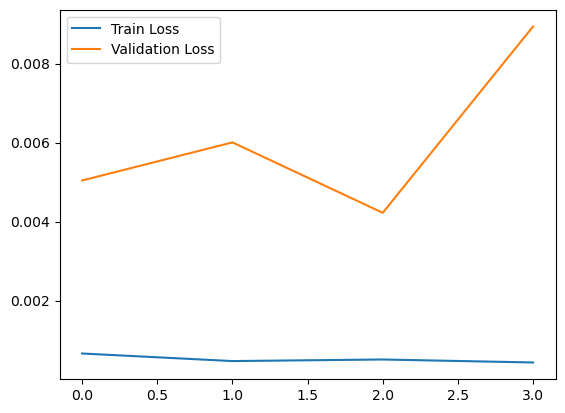

In [12]:

# Создание модели
model = create_model(X_train_ltsm)

# Обучение модели
history = train_model(model, X_train_ltsm, y_train_ltsm, X_test_ltsm, y_test_ltsm, file_id)

# Визуализация истории обучения
plot_training_history(history)

16/16 [==============================] - 1s 10ms/step


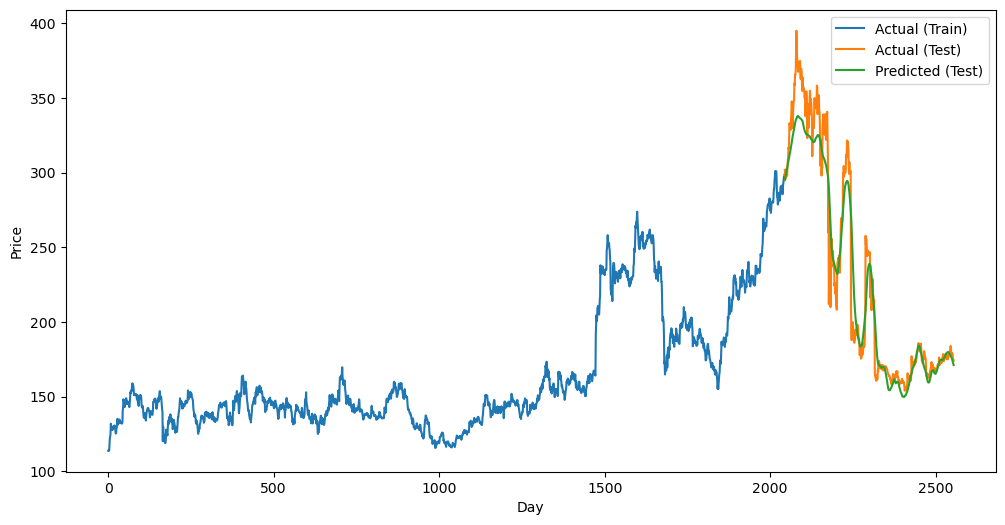

In [13]:
yhat = model.predict(X_test_ltsm)
X_train_ltsm_res = X_train_ltsm.reshape((X_train_ltsm.shape[0], n_intervals*n_features))
X_test_ltsm_res = X_test_ltsm.reshape((X_test_ltsm.shape[0], n_intervals*n_features))

inv_y_train = invert_scaling_for_actual(y_train_ltsm, X_train_ltsm_res, n_features, scaler)
inv_yhat = invert_scaling_for_forecast(yhat, X_test_ltsm_res, n_features, scaler)
inv_y_test = invert_scaling_for_actual(y_test_ltsm, X_test_ltsm_res, n_features, scaler)

plot_results(inv_y_train, inv_y_test, inv_yhat)

In [14]:
# Использование функции для расчета метрик
metrics = calculate_metrics(inv_y_test, inv_yhat)

# Вывод результатов
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.3f}")

RMSE: 17.528
MAE: 11.782
MAPE: 4.692
R-squared: 0.944


4/4 [==============================] - 0s 10ms/step


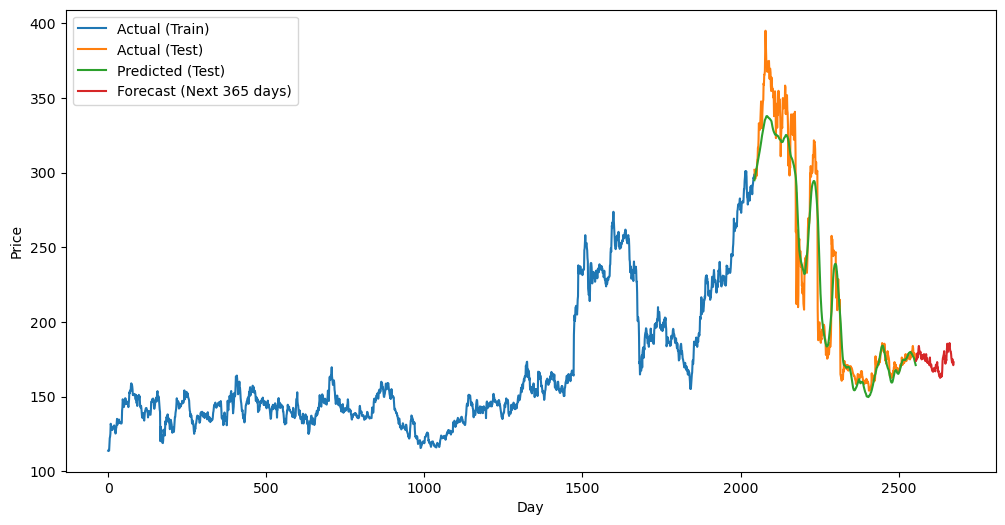

In [17]:
# Прогноз на следующие n_intervals дней
forecast_days = 365  # Замените на необходимое количество дней прогноза

forecast = forecast_next_days(model, X_test_ltsm,y_test_ltsm = y_test_ltsm,forecast_days=forecast_days, n_intervals=n_intervals, n_features=n_features, scaler=scaler)
plot_forecast(inv_y_train, inv_y_test, inv_yhat, forecast,forecast_days=forecast_days)